In [1]:
import io
from pathlib import Path
import zipfile

import datamapplot
import datamapplot.selection_handlers
from matplotlib.colors import rgb2hex
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns
import umap
import vectorizers
import vectorizers.transformers

## Load Data

In [3]:
# Data URL from https://www.cs.cornell.edu/~arb/data/cat-edge-Cooking/
url = "https://drive.google.com/uc?export=download&id=16BTDEv3AC9l81FeU2US5nG30_CGsRTqk"
response = requests.get(url)
zip_file = io.BytesIO(response.content)
with zipfile.ZipFile(zip_file) as zf:
    print(zf.namelist())
    files = {name: zf.read(name) for name in zf.namelist()}

['cat-edge-Cooking/', 'cat-edge-Cooking/hyperedges.txt', 'cat-edge-Cooking/hyperedge-labels.txt', 'cat-edge-Cooking/hyperedge-label-identities.txt', 'cat-edge-Cooking/node-labels.txt', 'cat-edge-Cooking/README.txt']


Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-00-data-setup.ipynb .

In [4]:
ingredients_id = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/node-labels.txt"]), sep='\t', header=None)
ingredients_id.index = [x+1 for x in ingredients_id.index]
ingredients_id.columns = ['Ingredient']

In [5]:
recipes_with_id = [[int(ingredient) for ingredient in recipe.split("\t")] for recipe in
 files["cat-edge-Cooking/hyperedges.txt"].decode("utf8").strip().split("\n")]

In [6]:
recipes_all = [[ingredients_id.loc[int(i)]['Ingredient'] for i in x] for x in recipes_with_id]

In [7]:
recipe_min_size = 3
recipes = [recipe for recipe in recipes_all if len(recipe) > recipe_min_size]

In [8]:
keep_recipes = np.array([len(recipe) > recipe_min_size for recipe in recipes_all])

In [9]:
recipes_label_id_all = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-labels.txt"]), sep='\t', header=None)
recipes_label_id_all.columns = ['label']
recipes_label_id = recipes_label_id_all.iloc[keep_recipes].reset_index()

In [10]:
label_name = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-label-identities.txt"]), sep='\t', header=None)
label_name.columns = ['country']
label_name.index = [x+1 for x in label_name.index]

In [11]:
recipes_country = [label_name.loc[i]['country'] for i in recipes_label_id.label] 

In [12]:
recipe_metadata = pd.DataFrame()
recipe_metadata['Country'] = recipes_country
recipe_metadata['Ingredients'] = recipes
recipe_metadata['Recipe_size'] = [len(x) for x in recipes]

In [13]:
region_to_countries_map = {
    'Asian' : ('chinese', 'filipino', 'japanese','korean', 'thai', 'vietnamese'),
    'American' : ('brazilian', 'mexican', 'southern_us'),
    'British Isles' : ('british', 'irish'),
    'Caribbean' : ('cajun_creole', 'jamaican'),
    'European' : ('french', 'italian', 'spanish', 'greek', 'russian'),
    'Unlabelled' : ('indian', 'moroccan')
}

In [14]:
country_to_region_map = {country: region for region, countries in region_to_countries_map.items() for country in countries}

In [15]:
recipe_metadata["Region"] = recipe_metadata["Country"].map(country_to_region_map)

## Embed

Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-03-joint-annotated.ipynb .

In [17]:
def vertexCooccurrenceVectorizer(hyperedges):
    vertexCooccurrence_vectorizer = vectorizers.TokenCooccurrenceVectorizer().fit(hyperedges)
    
    incidence_vectorizer = vectorizers.NgramVectorizer(
        token_dictionary=vertexCooccurrence_vectorizer.token_label_dictionary_
    ).fit(hyperedges)

    H = incidence_vectorizer.transform(hyperedges)
    
    M_cooccurrence = (H.T@H)
    M_cooccurrence.setdiag(0)
    M_cooccurrence.eliminate_zeros()
    
    vertexCooccurrence_vectorizer.cooccurrences_ = M_cooccurrence
    
    return(vertexCooccurrence_vectorizer)

In [ ]:
ingredient_vectorizer = vertexCooccurrenceVectorizer(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")
n_ingredients = len(ingredient_vectorizer.token_index_dictionary_)
ingredients = [ingredient_vectorizer.token_index_dictionary_[i] for i in range(n_ingredients)]

In [19]:
ingredient_metadata = pd.DataFrame({"Ingredients": [[x] for x in ingredients], "Country": "Unlabelled", "Region": "Unlabelled", "Recipe_size": 1})

df = pd.concat([recipe_metadata, ingredient_metadata], axis=0)

n_recipes = len(recipes)

is_ingredient = np.hstack([np.zeros(n_recipes),
                           np.ones(n_ingredients)]).astype(bool)

df["Is_ingredient"] = is_ingredient

In [20]:
df["Country"] = df["Country"].str.replace("_", " ").str.title()

In [21]:
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit(recipes)

incidence_matrix = incidence_vectorizer.transform(recipes)

In [22]:
info_weighted_incidence = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(incidence_matrix)

In [23]:
info_doc_with_identity = scipy.sparse.vstack([info_weighted_incidence, scipy.sparse.identity(n_ingredients)])

In [24]:
joint_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.25,
    random_state=42,
).fit_transform(info_doc_with_identity, vectors=ingredient_vectors)

In [ ]:
joint_vectors_mapper = umap.UMAP(metric="cosine", random_state=42).fit(joint_vectors_unsupervised)

In [26]:
df["x"] = joint_vectors_mapper.embedding_[:, 0]
df["y"] = joint_vectors_mapper.embedding_[:, 1]

In [27]:
df.to_parquet(Path("../data/recipes.parquet"))

## Data Map

In [2]:
df = pd.read_parquet(Path("../data/recipes.parquet"))

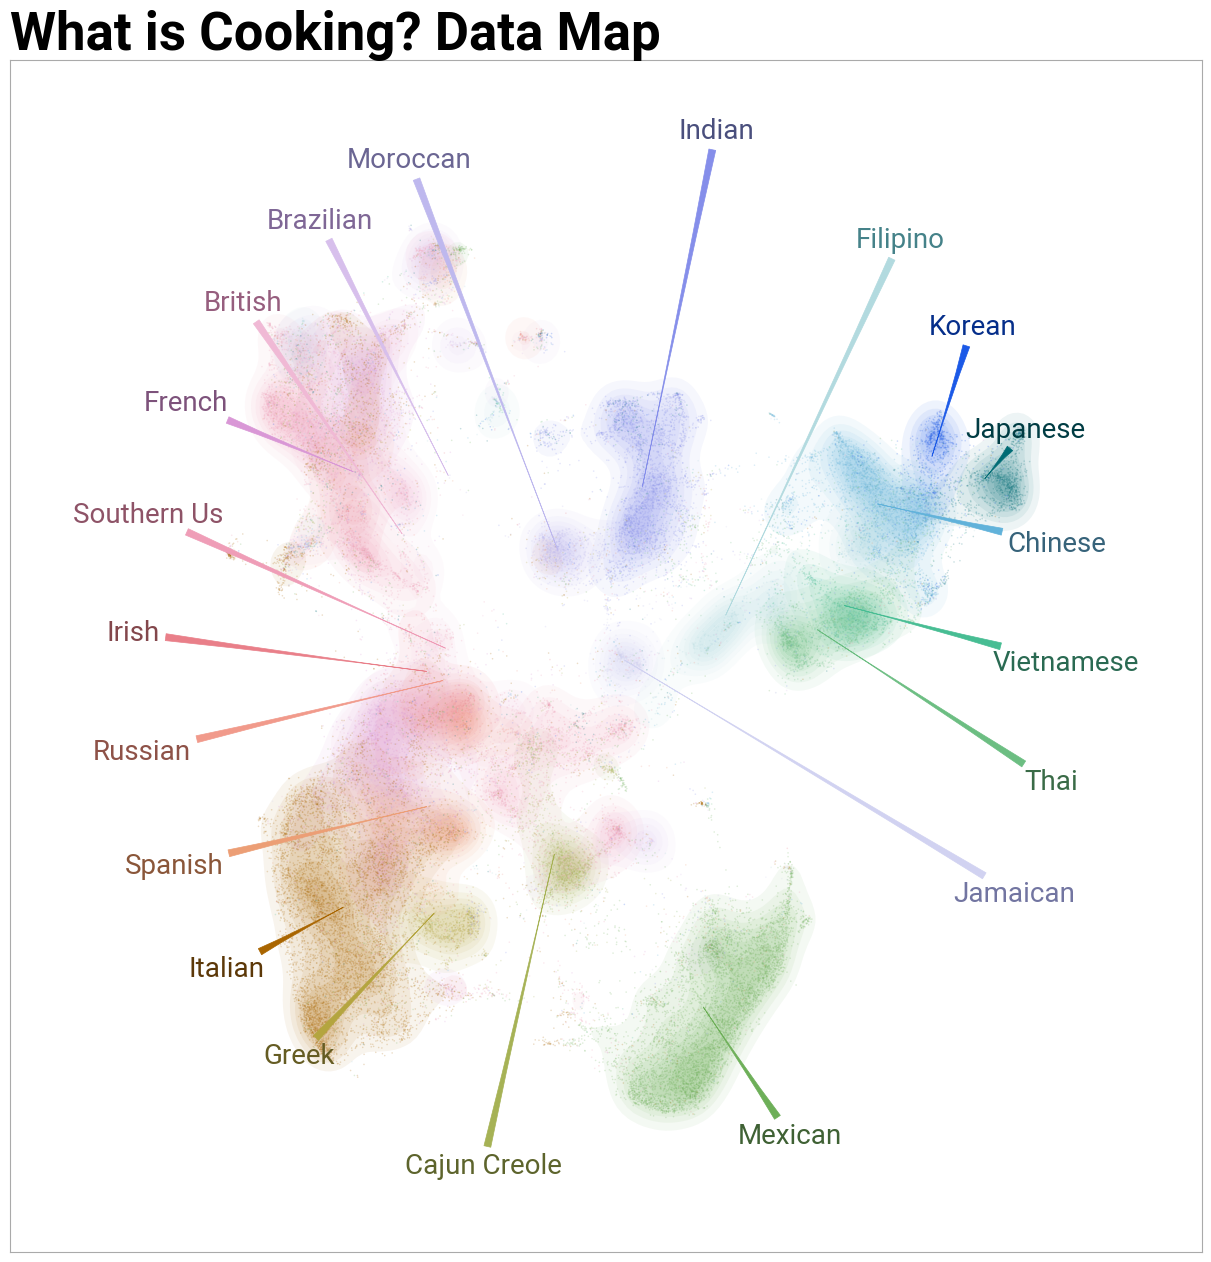

In [3]:
fig, ax = datamapplot.create_plot(
    df.loc[~df["Is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["Is_ingredient"], "Country"],
    title="What is Cooking? Data Map",
    label_font_size=20,
    use_medoids=True,
    color_label_arrows=True, 
    arrowprops={"arrowstyle": "wedge, tail_width=0.25, shrink_factor=0.25"},
)

In [5]:
all_labels = np.unique(df.loc[~df["Is_ingredient"], "Country"])
color_mapping = dict(
    zip(
        np.unique(all_labels),
        map(rgb2hex, sns.color_palette("tab20", len(all_labels)))
    )
)

In [6]:
custom_css="""
.row {
    display : flex;
    align-items : center;
}
.box {
    height:10px;
    width:10px;
    border-radius:2px;
    margin-right:5px;
    padding:0px 0 1px 0;
    text-align:center;
    color: white;
    font-size: 14px;
    cursor: pointer;
}
#legend {
    position: absolute;
    top: 0;
    right: 0;
}
#title-container {
    max-width: 75%;
}
"""

custom_html = """
<div id="legend" class="container-box">
"""
for field, color in color_mapping.items():
    custom_html += f'    <div class="row"><div id="{field}" class="box" style="background-color:{color};"></div>{field}</div>\n'
custom_html += """
</div>
"""

custom_js = """
const legend = document.getElementById("legend");
const selectedPrimaryFields = new Set();

legend.addEventListener('click', function(event) {
    const selectedField = event.srcElement.id;

    if (selectedField) {
        if (selectedPrimaryFields.has(selectedField)) {
            selectedPrimaryFields.delete(selectedField);
            event.srcElement.innerHTML = "";
        } else {
            selectedPrimaryFields.add(selectedField);
            event.srcElement.innerHTML = "✓";
        }
    }
    const selectedIndices = [];
    datamap.metaData.primary_field.forEach((field, i) => {
        if (selectedPrimaryFields.has(field)) {
            selectedIndices.push(i);
        }
    });
    datamap.addSelection(selectedIndices, "legend");
});
"""

hover_text_template = """
<div>
    <p>COUNTRY: {primary_field}</p>
    <p>INGREDIENTS: {hover_text}</p>
</div>
"""

In [7]:
extra_data = pd.DataFrame(
    {"primary_field": df.loc[~df["Is_ingredient"], "Country"]}
)

In [8]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["Is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["Is_ingredient"], "Country"],
    df.loc[~df["Is_ingredient"], "Region"],
    title="What is Cooking? Data Map",
    inline_data=True,
    hover_text=df.loc[~df["Is_ingredient"], "Ingredients"].map(" , ".join),
    hover_text_html_template=hover_text_template,
    extra_point_data=extra_data,
    selection_handler=datamapplot.selection_handlers.WordCloud(100, width=500, height=300, n_rotations=0),
    use_medoids=True,
    enable_search=True,
)
# Change the word counter's behaviour to split on commas instead of whitespace.
plot._html_str = plot._html_str.replace("textItems.join(' ').toLowerCase().split(/\s+/);",
                                        "textItems.join(' ').toLowerCase().split(/,\s*/);")

In [9]:
plot

<InteractiveFigure width=100% height=800>

In [10]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["Is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["Is_ingredient"], "Country"],
    use_medoids=True,
    title="What is Cooking? Data Map",
    label_color_map=color_mapping,
    inline_data=True,
    hover_text=df.loc[~df["Is_ingredient"], "Ingredients"].map(", ".join),
    hover_text_html_template=hover_text_template,
    selection_handler=datamapplot.selection_handlers.WordCloud(100, width=500, height=300, n_rotations=0),
    cluster_boundary_polygons=True,
    extra_point_data=extra_data,
    enable_search=True,
    custom_css=custom_css,
    custom_html=custom_html,
    custom_js=custom_js,
)
# Change the word counter's behaviour to split on commas instead of whitespace.
plot._html_str = plot._html_str.replace("textItems.join(' ').toLowerCase().split(/\s+/);",
                                        "textItems.join(' ').toLowerCase().split(/,\s*/);")

/home/jupyterhub/.conda/envs/jupyterhub/lib/python3.11/site-packages/datamapplot/alpha_shapes.py:47: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 's' of function 'ol_set_copy.<locals>.<lambda>'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../.local/lib/python3.11/site-packages/numba/cpython/setobj.py", line 1409:

def set_difference_update(context, builder, sig, args):
^

  search_set = boundary.copy()
/home/jupyterhub/.conda/envs/jupyterhub/lib/python3.11/site-packages/datamapplot/alpha_shapes.py:48: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected set' found for argument 's' of function 'ol_set_pop.<locals>.<lambda>'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of

In [11]:
plot

<InteractiveFigure width=100% height=800>

In [12]:
plot.save(Path("../recipes_datamapplot.html"))